# Introducing cost-dependent traffic and optimisation to AeroMAPS

This notebook presents and exploits results obtained for a submitted publication. 

Major hypotheses taken for the illustrative use case are presented first, and the results are loaded from other notebooks dedicated to several case studies.


### Imports and settings

In [ ]:
import pandas as pd
import json
import matplotlib.cm as cm
import numpy as np
from scipy.interpolate import griddata


%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

mpl.rcParams.update(
    {
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 14,
        "legend.fontsize": 12,
        "legend.title_fontsize": 13,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
)

## 1- Default scenario parameters presenation and settings

--> Most Parameters directly set in the (./data/inputs.json) file, and are discussed below.

- Air traffic evolution   
We consider an exogenous growth rate, which is the one that would occur considering a technological/fiscal situation frozen in 2019. 
For the purposes of this article, an uniform growth rate of 2.2% is set, as the average of the following models. This is lower than industry prospects for europe such as [Airbus GMF: 2.76%](https://www.airbus.com/sites/g/files/jlcbta136/files/2025-06/Presentation%20GMF%202025-2044.pdf) or [Boeing CMO: 3.1%](https://www.boeing.com/content/dam/boeing/boeingdotcom/market/assets/downloads/2025-commercial-market-outlook.pdf), but higher than [IEA Net Zero: 2.1% (2019 as base year)](https://www.iea.org/reports/net-zero-roadmap-a-global-pathway-to-keep-the-15-0c-goal-in-reach). Airbus figure is for western europe only (own computation from flows data), while Boeing includes eastern Europe. EU includes elements of both. [EASA](https://www.easa.europa.eu/sites/default/files/eaer-downloads/EASA_EAER_2025_Book_v5.pdf) reports figures between 1.3 and 1.8%, their modelling taking into account ReFuelEU.


- Aircraft fleet  -> See the [callibration notebook](./callibration_on_fleet.ipynb).  
A new aicraft is introduced in every category: in 2035 with -20% fuel burn (compared to recent reference) for short and medium range, in 2040 with -30% compared to recent reference for long range.
Theoretically, the optimisation could be run directly with the fleet model. However, AeroMAPS also has a faster simple annual efficiency gains model, which is going to be used in this work; after being callibarted once and for all in the notebook.  
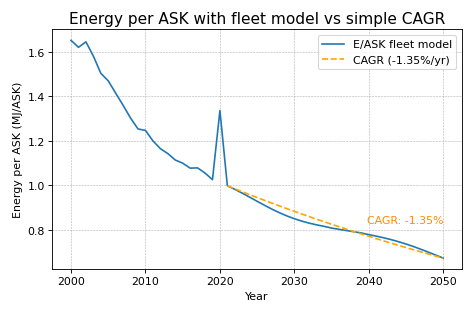  
The Mean annual efficiency improvemen is 1.35% 

- Operational improvements are considered via two opportunities.
    - Load factor improvement: improvement to 89% at the end of the scenario. 
    - Operational efficiency (better ATM, aircrfat MRO and operational optimisation): improvement of 8% in 25y.   
    
    Cost savings occur through the fuel savings. However, it could come at an extra cost (non-energy). This parameter is modelled in AeroMAPS, but not considered in this article due to lack of specific informations to the best of our knowldege.


- Energy  
As with the fleet model, aeromaps has both bottom up (plant specific) and simplified models for alternative energies. The latter are used for faster run time has optimisation involves many evaluations of AeroMAPS compute function.
We callibarte the top-down model based on the values considered in [this article](https://doi.org/10.1016/j.trd.2025.104836).  
It comes with a price: MFSP (energy price) full computation is more rigorous: enegries average price used here depend on the production trajectory used for the callibartion.  
To ease the optimisation problem, a fixed mix of the various biofuels pathways available is considered, whose share are based on the ressources available for each pathway. 
The emission factor and minimal selling price trajectories are given below.  
*Emission Factor*:  
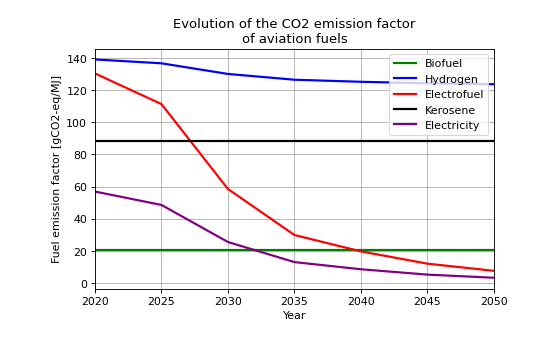  
*MFSP*:  
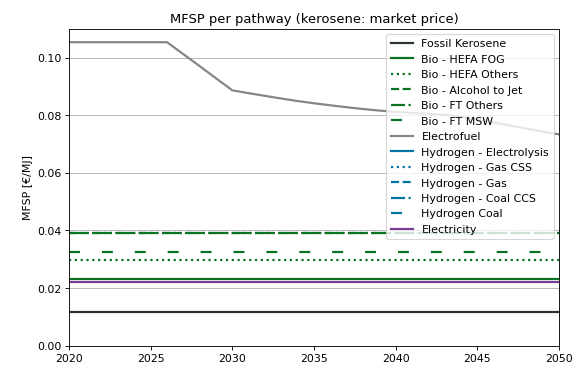


Besides, various constraints are defined and extensively described in the artcile. These include absolute biomass and electricity availability, as well as ramp up constraints. 


- Carbon budget  
A budget corresponfing to limiting global warming to +1.8° with 67% chances is considered (850 GTCO2 + 285 GTCO2 CDR).  As explained in the artcile, a share of this budget is used as an objective for the various optimisation runs.

- Socio-economic  
A 4.5% social discount rate is considered.



## 2- Scenario regionalisation

The optimisation is applied to flight leaving the European Union. Thus AeroMAPS is callibrated using https://aeroscope.isae-supaero.fr/

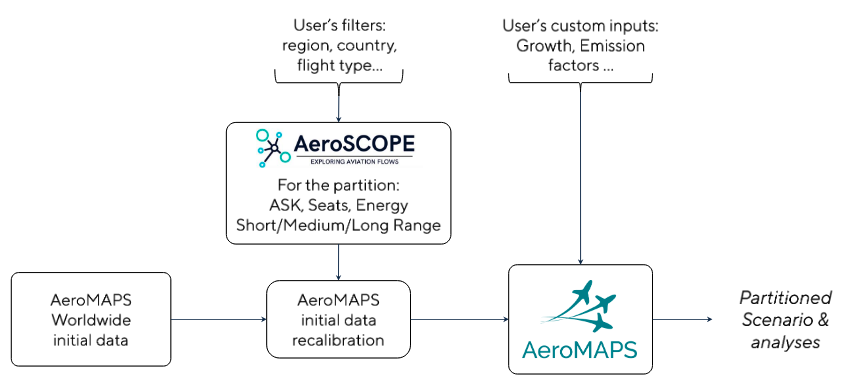

## 3- Market model testing and selection

The newly developped model to take into account the cost-dependant traffic is tested in [this notebook](./equilibriums.ipynb)

## 4- Optimisation runs

To keep this notebbok short and clear, the optimisation are run remotely and imported hereafter. 
More specifically: 

- [Main case](./run_opt_main_B099.ipynb) 

Sensitivity on biomass allocated:  
- [15% of biomass](./run_opt_B15.ipynb)
- [7.5% of biomass](./run_opt_B075.ipynb)
- [5% of biomass](./run_opt_B05.ipynb)

Sensitivity on aircraft technology:  
- [Pessimistic](./run_opt_B099_P.ipynb)


## 5 - Post process and results exploitation

### 5-a) Individual optimisation results

In [ ]:
# Given run
with open("results/opt_main_2_8.json", "r") as f:
    data = json.load(f)
    vec_out = data.get("vector_outputs", {})
    float_out = data.get("float_outputs", {})

process_ex_data = vec_out

# BAU reference
with open("results/foss.json", "r") as f:
    data_foss = json.load(f)
    vec_out_foss = data_foss.get("vector_outputs", {})
    float_out_foss = data_foss.get("float_outputs", {})

process_ex_data_foss = vec_out_foss

In [ ]:
# Redefining constraints for plots

biomass_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
biomass_availability_constraint_trajectory_reference_years_values = [
    62.8,
    72.1,
    97.8,
    101.8,
]


aviation_available_biomass = (
    9.9 * 0.1549 / 100 * np.array(biomass_availability_constraint_trajectory_reference_years_values)
)

biofuel_max_availability_viz = 4.75999416e11 * aviation_available_biomass / 1e12

electricity_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
electricity_availability_constraint_trajectory_reference_years_values = [
    102.0456,
    137.5452,
    212.7996,
    276.6168,
]


aviation_available_electricicty = (
    5
    * 0.1549
    / 100
    * np.array(electricity_availability_constraint_trajectory_reference_years_values)
)


electrofuel_max_availability_viz = 4.366e11 * aviation_available_electricicty / 1e12

# # --- avg eff for biomass to fuel viz
# print(np.array(process_ex_data['energy_consumption_biofuel']) / np.array(process_ex_data['biomass_consumption']))
# print(np.array(process_ex_data['energy_consumption_electrofuel']) / np.array(process_ex_data['electricity_consumption']))

In [ ]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))

year_range = list(range(2000, 2051))

ax1.plot(
    year_range,
    process_ex_data["biofuel_share"],
    color="#7e9b59",
    linestyle="-",
    label="Biofuel",
    linewidth=2,
)

ax1.plot(
    year_range,
    process_ex_data["electrofuel_share"],
    color="#092054",
    linestyle="-",
    label="Electrofuel",
    linewidth=2,
)

ax1.plot(
    year_range,
    process_ex_data["kerosene_share"],
    color="#cb3629",
    linestyle="-",
    label="Fossil",
    linewidth=2,
)

ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [0, 2, 4.8, 15, 24, 27, 35],
    color="#7e9b59",
    linestyle="--",
    label="Biofuel - R.EU",
    linewidth=2,
)

ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [0, 0, 1.2, 5, 10, 15, 35],
    color="#092054",
    linestyle="--",
    label="Electrofuel - R.EU",
    linewidth=2,
)

ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [100, 98, 94.0, 80, 66, 58, 30],
    color="#cb3629",
    linestyle="--",
    label="Fossil - R.EU",
    linewidth=2,
)

ax1.grid()
ax1.legend()
ax1.set_ylabel("Drop-in Fuel Shares")
ax1.set_xlim(2021, 2051)
ax1.set_title("Blending Mandate")

# === Parameters ===
rate_ramp_up_b = 0.2
volume_ramp_up_b = 0.2 * 0.1549 * 1e12

rate_ramp_up_e = 0.2
volume_ramp_up_e = 0.2 * 0.1549 * 1e12

# === Year ranges ===
year_range = list(range(2000, 2051))
step_years = list(range(2030, 2051, 5))

# === Energy series ===
energy_b = pd.Series(process_ex_data["energy_consumption_biofuel"], index=year_range)
energy_e = pd.Series(process_ex_data["energy_consumption_electrofuel"], index=year_range)


# === Function to build sawtooth series with max constraint ===
def build_sawtooth_max(energy, rate, volume):
    years = [year_range[25]]  # start at 2025
    values_rate = [energy.loc[2025] / 1e12]
    values_vol = [energy.loc[2025] / 1e12]

    for year in step_years:
        prev_val = energy.loc[year - 5]
        val_rate = prev_val * (1 + rate) ** 5
        val_vol = prev_val + volume * 5

        # same year: constraint then actual
        years.extend([year, year])
        values_rate.extend([val_rate / 1e12, energy.loc[year] / 1e12])
        values_vol.extend([val_vol / 1e12, energy.loc[year] / 1e12])

    return years, values_rate, values_vol


# === Build sawtooth series ===
years_b, vals_rate_b, vals_vol_b = build_sawtooth_max(energy_b, rate_ramp_up_b, volume_ramp_up_b)
years_e, vals_rate_e, vals_vol_e = build_sawtooth_max(energy_e, rate_ramp_up_e, volume_ramp_up_e)

# --- Compute max of sawtooth for fill ---
max_b = [max(r, v) for r, v in zip(vals_rate_b, vals_vol_b)]
max_e = [max(r, v) for r, v in zip(vals_rate_e, vals_vol_e)]


# === Plot Biofuel ===
ax2.plot(
    year_range,
    np.array(process_ex_data["energy_consumption_biofuel"]) / 1e12,
    color="#7e9b59",
    linestyle="-",
    linewidth=3,
    label="Actual consumption",
)
ax2.plot(years_b, vals_rate_b, linestyle=":", color="#CCCCCC", linewidth=2, label="Ramp-up (rate)")
ax2.plot(years_b, vals_vol_b, linestyle="--", color="#CCCCCC", linewidth=1.5, label="Ramp-up (vol)")

ax2.plot(
    [2020, 2030, 2040, 2050],
    biofuel_max_availability_viz,
    color="#555555",
    linestyle="-",
    linewidth=1,
    label="Resource constraint",
)
ax2.fill_between(
    [2020, 2030, 2040, 2050],
    biofuel_max_availability_viz,
    3,
    hatch="//",
    edgecolor="#E0E0E0",
    facecolor="none",
    linewidth=0,
    alpha=0.1,
)

# --- Fill above max ramp-up ---
ax2.fill_between(
    years_b, max_b, 1.5, hatch="\\\\", facecolor="none", edgecolor="#E0E0E0", alpha=0.1
)

ax2.set_ylabel("Consumption [EJ]")
ax2.set_xlim(2021, 2051)
ax2.set_ylim(-0.05, 1.5)
ax2.grid()
ax2.legend(loc="upper left")
ax2.set_title("Biofuel")

# === Plot Electrofuel ===
ax3.plot(
    year_range,
    np.array(process_ex_data["energy_consumption_electrofuel"]) / 1e12,
    color="#092054",
    linestyle="-",
    linewidth=2.5,
    label="Actual consumption",
)
ax3.plot(years_e, vals_rate_e, linestyle=":", color="#CCCCCC", linewidth=2, label="Ramp-up (rate)")
ax3.plot(years_e, vals_vol_e, linestyle="--", color="#CCCCCC", linewidth=1.5, label="Ramp-up (vol)")

ax3.plot(
    [2020, 2030, 2040, 2050],
    electrofuel_max_availability_viz,
    color="#555555",
    linestyle="-",
    linewidth=1,
    label="Resource constraint",
)
ax3.fill_between(
    [2020, 2030, 2040, 2050],
    electrofuel_max_availability_viz,
    3,
    hatch="//",
    edgecolor="#E0E0E0",
    facecolor="none",
    linewidth=0,
    alpha=0.1,
)

# --- Fill above max ramp-up --
ax3.fill_between(
    years_e, max_e, 1.5, hatch="\\\\", facecolor="none", edgecolor="#E0E0E0", alpha=0.1
)

ax3.set_ylabel("Consumption [EJ]")
ax3.set_xlim(2021, 2051)
ax3.set_ylim(-0.05, 1.5)
ax3.grid()
ax3.legend(loc="upper left")
ax3.set_title("Electrofuel")

fig.tight_layout()
fig.savefig("ressource_constraints.pdf")

In [ ]:
# Final year airline cost increase vs Business As Usual
process_ex_data["total_cost_per_rpk"][-1] / process_ex_data_foss["total_cost_per_rpk"][-1]

In [ ]:
# Final year airline cost increase vs Business As Usual
process_ex_data["airfare_per_rpk"][-1] / process_ex_data_foss["airfare_per_rpk"][-1]

In [ ]:
# Final year traffic reduction vs iso-2019 system growth hypothesis
process_ex_data["rpk"][-1] / process_ex_data["rpk_no_elasticity"][-1]

In [ ]:
# Final year traffic reduction vs Business As Usual
process_ex_data["rpk"][-1] / process_ex_data["rpk_no_elasticity"][-1]

In [ ]:
# Final year CO2 vs Business As Usual
process_ex_data["co2_emissions_including_energy"][-1] / process_ex_data_foss[
    "co2_emissions_including_energy"
][-1]

In [ ]:
# Cumulative CO2 vs Business As Usual
process_ex_data["cumulative_co2_emissions"][-1] / process_ex_data_foss["cumulative_co2_emissions"][
    -1
]

In [ ]:
# 2025-2050 CAGR
((process_ex_data["rpk"][50] / process_ex_data["rpk"][25]) ** (1 / 25) - 1) * 100

In [ ]:
# 2025-2050 CAGR BAU
((process_ex_data_foss["rpk"][50] / process_ex_data_foss["rpk"][25]) ** (1 / 25) - 1) * 100

### 5-b) Main case carbon budget sensitivity study

In [ ]:
file_paths = {
    "Min $CO_2$": "results/opt_main_mincarb.json",
    "2.2": "results/opt_main_2_2.json",
    "2.4": "results/opt_main_2_4.json",
    "2.6": "results/opt_main_2_6.json",
    "2.8": "results/opt_main_2_8.json",
    "3.0": "results/opt_main_3_0.json",
    "3.2": "results/opt_main_3_2.json",
    "3.4": "results/opt_main_3_4.json",
    "3.6": "results/opt_main_3_6.json",
    "3.8": "results/opt_main_3_8.json",
    "Fossil": "results/foss.json",
    "ReFuelEU": "results/refeu.json",
}


results = {}

for name, path in file_paths.items():
    with open(path, "r") as f:
        data = json.load(f)
        vec_out = data.get("vector_outputs", {})
        float_out = data.get("float_outputs", {})

        # Get results of interest in vec out.
        results[name] = {
            "carbon_budget_consumed_share": float_out.get("carbon_budget_consumed_share")
            / 0.1549,  # get from europe to world value for readability
            "cumulative_total_surplus_loss_discounted": vec_out.get(
                "cumulative_total_surplus_loss_discounted"
            )[-1],
            "cumulative_total_airline_cost_increase_discounted": vec_out.get(
                "cumulative_total_airline_cost_increase_discounted"
            )[-1],
            "biofuel_share": vec_out.get("biofuel_share"),
            "electrofuel_share": vec_out.get("electrofuel_share"),
            "kerosene_share": vec_out.get("kerosene_share"),
            "energy_consumption_biofuel": vec_out.get("energy_consumption_biofuel"),
            "energy_consumption_electrofuel": vec_out.get("energy_consumption_electrofuel"),
            "rpk": vec_out.get("rpk"),
            "rpk_no_elasticity": vec_out.get("rpk_no_elasticity"),
            "airfare_per_rpk": vec_out.get("airfare_per_rpk"),
        }


labels = list(results.keys())
co2_share = [results[k]["carbon_budget_consumed_share"] for k in labels]
surplus_loss = [results[k]["cumulative_total_surplus_loss_discounted"] for k in labels]


plt.figure(figsize=(10, 6))
plt.scatter(co2_share, surplus_loss, c="darkred")

for i, label in enumerate(labels):
    plt.annotate(
        label, (co2_share[i], surplus_loss[i]), textcoords="offset points", xytext=(5, 5), ha="left"
    )

plt.xlabel("Carbon Budget Consumed Share")
plt.ylabel("Cumulative Total Surplus Loss (Discounted)")
plt.title("Carbon Budget Use VS Surplus Loss")
plt.grid(True)
plt.tight_layout()

In [ ]:
# Shares, traffic and airfare for main case sensitivity study

# COLORMAP definition
scenario_names = list(results.keys())
cmap = cm.get_cmap("Blues", len(scenario_names))
lower, upper = 0.3, 1.0
colors = [cmap(x) for x in np.linspace(lower, upper, len(scenario_names))]
year_range = list(range(2000, 2051))


fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex="col")

# Biofuel Share
for i, name in enumerate(scenario_names):
    axs[0, 0].plot(year_range, results[name]["biofuel_share"], label=name, color=colors[i])
axs[0, 0].set_ylabel("Biofuel Share (%)")
axs[0, 0].set_title("Biofuel Share")
axs[0, 0].set_ylim(-1, 60)
axs[0, 0].set_xlim(
    2019,
)
axs[0, 0].grid(True)

# Electrofuel Share
for i, name in enumerate(scenario_names):
    axs[1, 0].plot(year_range, results[name]["electrofuel_share"], label=name, color=colors[i])
axs[1, 0].set_xlabel("Year")
axs[1, 0].set_ylabel("Electrofuel Share (%)")
axs[1, 0].set_title("Electrofuel Share")
axs[1, 0].set_ylim(-1, 60)
axs[0, 0].set_xlim(
    2019,
)
axs[1, 0].grid(True)

# RPK
for i, name in enumerate(scenario_names):
    axs[0, 1].plot(year_range, results[name]["rpk"], color=colors[i])
axs[0, 1].plot(
    year_range, results[name]["rpk_no_elasticity"], label="No elasticity", color="black", ls="--"
)
axs[0, 1].set_ylabel("RPK")
axs[0, 1].set_title("Traffic")
axs[0, 1].grid(True)
axs[0, 1].set_ylim(
    0,
)
axs[0, 1].set_xlim(
    2019,
)
axs[0, 1].legend(loc="lower right")

# Airfare per RPK
results[name]["airfare_per_rpk"][19] = 0.09236379319842411
for i, name in enumerate(scenario_names):
    axs[1, 1].plot(year_range, results[name]["airfare_per_rpk"], color=colors[i])
axs[1, 1].plot(
    range(2019, 2051),
    [0.09236379319842411] * len(range(2019, 2051)),
    label="2019 Airfare",
    color="black",
    ls="--",
)
axs[1, 1].set_xlabel("Year")
axs[1, 1].set_ylabel("Airfare per RPK (€)")
axs[1, 1].set_title("Airfare")
axs[1, 1].set_ylim(0.06, 0.15)
axs[1, 1].grid(True)
axs[1, 1].legend()

# adjust right margin to leave space for the legend
fig.subplots_adjust(right=0.8)
fig.legend(
    scenario_names, loc="center left", bbox_to_anchor=(0.88, 0.5), frameon=True, title="Objective"
)
plt.tight_layout(rect=[0, 0, 0.88, 1])


plt.savefig("overall.pdf")

### 5-c) Biomass allocation sensitivity study
Various plots proposed here, only surface in presented the article.

In [ ]:
# Define file paths
file_paths = {
    "process_mincarb": "results/opt_main_mincarb.json",
    # "process20": "results/opt_main_2_0.json", # not feasible
    "process22": "results/opt_main_2_2.json",
    "process24": "results/opt_main_2_4.json",
    "process26": "results/opt_main_2_6.json",
    "process28": "results/opt_main_2_8.json",
    "process30": "results/opt_main_3_0.json",
    "process32": "results/opt_main_3_2.json",
    "process34": "results/opt_main_3_4.json",
    "process36": "results/opt_main_3_6.json",
    "process38": "results/opt_main_3_8.json",
    "process_foss": "results/foss.json",
    # B15 scenarios
    # "process20_B15": "results/opt_B15_2_0.json", # not feasible
    "process22_B15": "results/opt_B15_2_2.json",
    "process24_B15": "results/opt_B15_2_4.json",
    "process26_B15": "results/opt_B15_2_6.json",
    "process28_B15": "results/opt_B15_2_8.json",
    "process30_B15": "results/opt_B15_3_0.json",
    "process32_B15": "results/opt_B15_3_2.json",
    "process34_B15": "results/opt_B15_3_4.json",
    "process36_B15": "results/opt_B15_3_6.json",
    "process38_B15": "results/opt_B15_3_8.json",
    "process_mincarb_B15": "results/opt_B15_mincarb.json",
    # B5 scenarios
    # "process20_B5": "results/opt_B5_2_0.json", # not feasible
    # "process22_B5": "results/opt_B5_2_2.json", # not feasible
    # "process24_B5": "results/opt_B5_2_4.json", # not feasible
    "process26_B5": "results/opt_B5_2_6.json",
    "process28_B5": "results/opt_B5_2_8.json",
    "process30_B5": "results/opt_B5_3_0.json",
    "process32_B5": "results/opt_B5_3_2.json",
    "process34_B5": "results/opt_B5_3_4.json",
    "process36_B5": "results/opt_B5_3_6.json",
    "process38_B5": "results/opt_B5_3_8.json",
    "process_mincarb_B5": "results/opt_B5_mincarb.json",
    # B75 scenarios
    # "process20_B75": "results/opt_B75_2_0.json", # not feasible
    # "process22_B75": "results/opt_B75_2_2.json", # not feasible
    "process24_B75": "results/opt_B75_2_4.json",
    "process26_B75": "results/opt_B75_2_6.json",
    "process28_B75": "results/opt_B75_2_8.json",
    "process30_B75": "results/opt_B75_3_0.json",
    "process32_B75": "results/opt_B75_3_2.json",
    "process34_B75": "results/opt_B75_3_4.json",
    "process36_B75": "results/opt_B75_3_6.json",
    "process38_B75": "results/opt_B75_3_8.json",
    "process_mincarb_B75": "results/opt_B75_mincarb.json",
}

# Colour mapping by scenario category
category_colours = {
    "main": "#cb3629",
    "B5": "#092054",
    "B15": "#efbd40",
    "B75": "#7e9b59",
    "foss": "lightgrey",
}


def get_category(name):
    if "B5" in name:
        return "B5"
    elif "B15" in name:
        return "B15"
    elif "B75" in name:
        return "B75"
    elif "foss" in name:
        return "foss"
    else:
        return "main"


results = {}
for name, path in file_paths.items():
    try:
        with open(path, "r") as f:
            data = json.load(f)
            vec_out = data.get("vector_outputs", {})
            float_out = data.get("float_outputs", {})
            results[name] = {
                "carbon_budget_consumed_share": float_out.get("carbon_budget_consumed_share")
                / 0.1549,
                "cumulative_total_surplus_loss_discounted": vec_out.get(
                    "cumulative_total_surplus_loss_discounted"
                )[-1],
                "category": get_category(name),
            }
    except FileNotFoundError:
        print(f"File not found: {path}")

# Prepare plot
plt.figure(figsize=(10, 6))

# Track which categories have already been added to the legend
plotted_categories = set()

for name, res in results.items():
    x = res["carbon_budget_consumed_share"]
    y = res["cumulative_total_surplus_loss_discounted"]
    category = res["category"]
    color = category_colours[category]
    label = category if category not in plotted_categories else None

    plt.scatter(x, y, color=color, label=label)
    # plt.annotate(name, (x, y), textcoords="offset points", xytext=(5, 5), ha='left') # --> option for scenarios names
    plotted_categories.add(category)

# Finalise plot
plt.xlabel("Carbon Budget Consumed Share")
plt.ylabel("Cumulative Total Surplus Loss (€, Discounted)")
plt.title("Trade-off between Carbon Budget Use and Surplus Loss")
plt.grid(True)
plt.legend(title="Scenario Category")
plt.tight_layout()
plt.show()

Possible 3D visualisation

In [ ]:
# Add biomass share allocation to each result entry
def get_biomass_share(name):
    if "B5" in name:
        return 5
    elif "B75" in name:
        return 7.5
    elif "B15" in name:
        return 15
    else:
        return 9.9


for res in results.values():
    res["biomass_share"] = get_biomass_share(res["category"])

# Fossil duplicates for each biomass share (same scenarios)
foss_result = results.get("process_foss")
if foss_result:
    for b in [5, 7.5, 9.9, 15]:
        new_foss = foss_result.copy()
        new_foss["biomass_share"] = b
        results[f"process_foss_{b}"] = new_foss

df = pd.DataFrame(results).T

# Prepare a grid
X = df["carbon_budget_consumed_share"].values
Y = df["biomass_share"].values
Z = df["cumulative_total_surplus_loss_discounted"].values

xi = np.linspace(min(X), max(X), 100)
yi = np.linspace(min(Y), max(Y), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate Z values on the grid
zi = griddata((X, Y), Z, (xi, yi), method="cubic")

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(xi, yi, zi, cmap="plasma", edgecolor="none", alpha=0.9)

# add original scenario points
ax.scatter(X, Y, Z, color="red", s=30, label="Scenario Points")

# add refuel-eu like point
with open("results/refeu.json", "r") as f:
    data_refeu = json.load(f)
    vec_out_refeu = data_refeu.get("vector_outputs", {})
    float_out_refeu = data_refeu.get("float_outputs", {})


ax.scatter(
    float_out_refeu.get("carbon_budget_consumed_share") / 0.1549,
    8.3979,
    vec_out_refeu.get("cumulative_total_surplus_loss_discounted")[-1],
    color="black",
    s=30,
    label="ReFuelEU",
    zorder=10,
)

# Labels and title
ax.set_xlabel("Carbon Budget Consumed Share")
ax.set_ylabel("Biomass Share (%)")
ax.set_zlabel("Cumulative Total Surplus Loss (€, Discounted)")
ax.set_title("Carbon budget / biomass alocated trade-off")

fig.colorbar(surf, shrink=0.5, aspect=5, label="Surplus Loss (€)")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
# Similar plot but in 2D

plt.figure(figsize=(10, 7))

vmin = zi.min()
vmax = zi.max()

# custom colormap to have 0 in white (part of teh colorbar is thus unexploited)
pcm = plt.pcolormesh(xi, yi, zi / 1e9, shading="gouraud", cmap="RdBu_r", vmin=-270, vmax=270)
contour_lines = plt.contour(xi, yi, zi / 1e9, levels=10, colors="black", linewidths=0.8)

labels = plt.clabel(contour_lines, inline=True, fontsize=11, fmt="%.1f", colors="white")

# Add black outline to each label for visibility
for txt in labels:
    txt.set_path_effects([pe.withStroke(linewidth=1, foreground="black")])

cbar = plt.colorbar(pcm)
cbar.set_label("Cumulative Total Surplus Loss (Bn€, Discounted)")

# Plot original scenario points by category
plotted_labels = set()
for name, res in results.items():
    x = res["carbon_budget_consumed_share"]
    y = res["biomass_share"]
    category = res["category"]
    color = category_colours.get(category, "grey")
    label = category if category not in plotted_labels else None

    plt.scatter(x, y, color=color, edgecolor="black", s=40, label=label)
    plotted_labels.add(category)


# Add some space around the contour surface
x_margin = 0.05 * (xi.max() - xi.min())
y_margin = 0.05 * (yi.max() - yi.min())

plt.xlim(xi.min() - x_margin, xi.max() + x_margin)
plt.ylim(yi.min() - y_margin, yi.max() + y_margin)

# Labels and title
plt.xlabel("Carbon Budget Consumed Share")
plt.ylabel("Biomass Share (%)")
plt.title("Carbon budget / biomass alocated trade-off")

plt.grid(True, ls="--")
plt.tight_layout()
plt.show()
plt.savefig("2d_shares.pdf")

In [ ]:
# Create 2D contour plot: Carbon Budget as contour

plt.figure(figsize=(10, 7))


contour = plt.contourf(yi, zi, xi, levels=10, cmap="plasma")  # xi = Z values (carbon budget)
contour_lines = plt.contour(yi, zi, xi, levels=10, colors="black", linewidths=0.8)
labels = plt.clabel(contour_lines, inline=True, fontsize=9, fmt="%.1f", colors="white")

# Add black outline to each label for visibility
for txt in labels:
    txt.set_path_effects([pe.withStroke(linewidth=1, foreground="black")])

cbar = plt.colorbar(contour)
cbar.set_label("Carbon Budget Consumed Share")


plotted_labels = set()
for name, res in results.items():
    x = res["biomass_share"]
    y = res["cumulative_total_surplus_loss_discounted"]
    z = res["carbon_budget_consumed_share"]
    category = res["category"]
    color = category_colours.get(category, "grey")

    plt.scatter(x, y, color=color, edgecolor="black", s=40, label=label)


# Labels and title
plt.xlabel("Biomass Share (%)")
plt.ylabel("Cumulative Total Surplus Loss (Discounted)")
plt.title("Carbon budget / biomass alocated trade-off")

plt.grid(True)
plt.tight_layout()
plt.show()

### 5-d) Pessimistic technology roadmap

In [ ]:
file_paths = {
    "Min $CO_2$ P": "results/opt_pess_mincarb.json",
    "2.6 P": "results/opt_pess_2_6.json",
    "2.8 P": "results/opt_pess_2_8.json",
    "3.0 P": "results/opt_pess_3_0.json",
    "3.2 P": "results/opt_pess_3_2.json",
    "3.4 P": "results/opt_pess_3_4.json",
    "3.6 P": "results/opt_pess_3_6.json",
    "3.8 P": "results/opt_pess_3_8.json",
    "Fossil P": "results/foss_pess.json",
    "Min $CO_2$": "results/opt_main_mincarb.json",
    "2.2": "results/opt_main_2_2.json",
    "2.4": "results/opt_main_2_4.json",
    "2.6": "results/opt_main_2_6.json",
    "2.8": "results/opt_main_2_8.json",
    "3.0": "results/opt_main_3_0.json",
    "3.2": "results/opt_main_3_2.json",
    "3.4": "results/opt_main_3_4.json",
    "3.6": "results/opt_main_3_6.json",
    "3.8": "results/opt_main_3_8.json",
    "Fossil": "results/foss.json",
}


category_colours = {"Reference": "#cb3629", "Low efficiency": "#092054", "foss": "lightgrey"}


# Categorise based on name
def get_category(name):
    if "P" in name:
        return "Low efficiency"
    else:
        return "Reference"


results = {}
for name, path in file_paths.items():
    with open(path, "r") as f:
        data = json.load(f)
        vec_out = data.get("vector_outputs", {})
        float_out = data.get("float_outputs", {})
        results[name] = {
            "carbon_budget_consumed_share": float_out.get("carbon_budget_consumed_share") / 0.1549,
            "cumulative_total_surplus_loss_discounted": vec_out.get(
                "cumulative_total_surplus_loss_discounted"
            )[-1],
            "category": get_category(name),
        }


plt.figure(figsize=(10, 6))
plotted_categories = set()


x_ref = []
y_ref = []
x_lo = []
y_lo = []

for name, res in results.items():
    x = res["carbon_budget_consumed_share"]
    y = res["cumulative_total_surplus_loss_discounted"] / 1e9
    category = res["category"]
    if category == "Reference":
        x_ref.append(x)
        y_ref.append(y)
    elif category == "Low efficiency":
        x_lo.append(x)
        y_lo.append(y)

    color = category_colours[category]
    label = category if category not in plotted_categories else None
    if "Min $CO_2$" in name:
        plt.annotate("Min $CO_2$", (x, y), textcoords="offset points", xytext=(5, 5), ha="left")
    if "Fossil" in name:
        plt.annotate("Fossil", (x, y), textcoords="offset points", xytext=(5, 5), ha="left")
    plotted_categories.add(category)


# Plot the delta?

# Sort the lists
x_ref, y_ref = zip(*sorted(zip(x_ref, y_ref)))
x_lo, y_lo = zip(*sorted(zip(x_lo, y_lo)))
# Interpolate Low efficiency onto all Reference x values, allowing extrapolation
y_lo_interp = np.interp(x_ref, x_lo, y_lo, left=y_lo[0], right=y_lo[-1])
# Compute difference
diff_y = [y_lo_interp[i] - y_ref[i] for i in range(len(x_ref))]


plt.plot(
    x_ref, y_ref, marker="o", linestyle="-", color=category_colours["Reference"], label="Reference"
)
plt.plot(
    x_lo,
    y_lo,
    marker="o",
    linestyle="-",
    color=category_colours["Low efficiency"],
    label="Low efficiency",
)

# Delta
plt.plot(
    x_ref[2:], diff_y[2:], marker="o", linestyle="--", color="black", label="Relative difference"
)

# Finalise plot
plt.xlabel("Carbon Budget Consumed Share (%)")
plt.ylabel("Total and relative surplus Loss (Bn€, discounted) ")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("technology.pdf")
plt.show()

Similar as the graph above but more detailled to compare two individual scenarios.  

In [ ]:
with open("results/opt_main_2_8.json", "r") as f:
    data = json.load(f)
    vec_out_ref = data.get("vector_outputs", {})
    float_out_ref = data.get("float_outputs", {})


with open("results/opt_pess_2_8.json", "r") as f:
    data_pess = json.load(f)
    vec_out_pess = data_pess.get("vector_outputs", {})
    float_out_pess = data_pess.get("float_outputs", {})

In [ ]:
year_range = list(range(2000, 2051))

# Annual revenues
rev_ref = (
    (np.array(vec_out_ref["airfare_per_rpk"]) - np.array(vec_out_ref["total_cost_per_rpk"]))
    * np.array(vec_out_ref["rpk"])
    / 1e9
)

rev_pess = (
    (np.array(vec_out_pess["airfare_per_rpk"]) - np.array(vec_out_pess["total_cost_per_rpk"]))
    * np.array(vec_out_pess["rpk"])
    / 1e9
)

rev_a = (
    (0.09236379319842411 - 0.08853131471704129) * np.array(vec_out_ref["rpk_no_elasticity"]) / 1e9
)


# Cumulative difference
cumulative_diff = np.sum(np.nan_to_num(rev_ref, nan=0.0) - np.nan_to_num(rev_pess, nan=0.0))
cumulative_diffa = np.sum(np.nan_to_num(rev_ref, nan=0.0) - np.nan_to_num(rev_a, nan=0.0))


plt.figure(figsize=(10, 6))
plt.plot(year_range, rev_ref, label="Ref. aircraft introduction scheme", color="#092054")
plt.plot(year_range, rev_pess, label="No technical innovation", color="#cb3629")
plt.plot(year_range, rev_a, label="No technical innovation", color="#cb3629")

plt.fill_between(year_range, rev_ref, rev_pess, alpha=0.1, color="#cb3629", label="Difference")

plt.text(2037, 7.4, f"Cumulative Δ = {cumulative_diff:.1f} Bn €", fontsize=12, color="black")

plt.xlabel("Year")
plt.ylabel("Airlines revenue (Bn €)")
plt.legend()
plt.grid(True)
plt.title("Airlines revenues evolution")


# np.sum(np.nan_to_num(rev_ref[25:], nan=0.0)) / np.sum(np.nan_to_num(rev_pess[25:], nan=0.0))

In [ ]:
year_range = list(range(2000, 2051))

# Annual spendings
rev_ref = (np.array(vec_out_ref["airfare_per_rpk"])) * np.array(vec_out_ref["rpk"]) / 1e9
rev_pess = (np.array(vec_out_pess["airfare_per_rpk"])) * np.array(vec_out_pess["rpk"]) / 1e9

cumulative_diff = np.sum(np.nan_to_num(rev_ref, nan=0.0) - np.nan_to_num(rev_pess, nan=0.0))

plt.figure(figsize=(10, 6))
plt.plot(year_range, rev_ref, label="Ref. aircraft introduction scheme", color="#092054")
plt.plot(year_range, rev_pess, label="No technical innovation", color="#cb3629")

plt.fill_between(year_range, rev_ref, rev_pess, alpha=0.1, color="#cb3629", label="Difference")

plt.text(2037, 100, f"Cumulative Δ = {cumulative_diff:.1f} Bn €", fontsize=12, color="black")

plt.xlabel("Year")
plt.ylabel("Passenger spending (Bn €)")
plt.legend()
plt.grid(True)
plt.title("Passenger spending evolution")

In [ ]:
year_range = list(range(2000, 2051))

# Annual RPK
rev_ref = np.array(vec_out_ref["rpk"]) / 1e9
rev_pess = np.array(vec_out_pess["rpk_no_elasticity"]) / 1e9

cumulative_diff = np.sum(np.nan_to_num(rev_ref, nan=0.0) - np.nan_to_num(rev_pess, nan=0.0))

plt.figure(figsize=(10, 6))
plt.plot(year_range, rev_ref, label="Ref. aircraft introduction scheme", color="#092054")
plt.plot(year_range, rev_pess, label="No technical innovation", color="#cb3629")
plt.fill_between(year_range, rev_ref, rev_pess, alpha=0.1, color="#cb3629", label="Difference")

plt.text(2037, 1000, f"Cumulative Δ = {cumulative_diff:.1f} Bn RPk", fontsize=12, color="black")

plt.xlabel("Year")
plt.ylabel("RPK (Bn)")
plt.title("RPK evolution")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
year_range = list(range(2000, 2051))


rev_ref = (
    np.array(vec_out_ref["area_loss"])
    - 0.09236379319842411
    * (np.array(vec_out_ref["rpk_no_elasticity"]) - np.array(vec_out_ref["rpk"]))
    + np.array(vec_out_ref["rpk"])
    * (np.array(vec_out_ref["airfare_per_rpk"]) - 0.09236379319842411)
) / 1e9
rev_pess = (
    np.array(vec_out_pess["area_loss"])
    - 0.09236379319842411
    * (np.array(vec_out_pess["rpk_no_elasticity"]) - np.array(vec_out_pess["rpk"]))
    + np.array(vec_out_pess["rpk"])
    * (np.array(vec_out_pess["airfare_per_rpk"]) - 0.09236379319842411)
) / 1e9

# Cumulative difference
cumulative_diff = np.sum(np.nan_to_num(rev_ref, nan=0.0) - np.nan_to_num(rev_pess, nan=0.0))

plt.figure(figsize=(10, 6))
plt.plot(year_range, rev_ref, label="Ref. aircraft introduction scheme", color="#092054")
plt.plot(year_range, rev_pess, label="No technical innovation", color="#cb3629")

# Fill between curves
plt.fill_between(year_range, rev_ref, rev_pess, alpha=0.1, color="#cb3629", label="Difference")

# Add cumulative difference as text (positioned around 2030)
plt.text(2037, 3, f"Cumulative Δ = {cumulative_diff:.1f} Bn €", fontsize=12, color="black")

plt.xlabel("Year")
plt.ylabel("Passenger Surplus Loss (Bn €)")
plt.legend()
plt.xlim(
    2020,
)
plt.grid(True)
plt.title("Relative passenger surplus loss evolution")

# np.sum(np.nan_to_num(rev_ref[25:], nan=0.0)), np.sum(np.nan_to_num(rev_pess, nan=0.0))